## 3. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

#### 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import xgboost
import lightgbm
import missingno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.3.3
3.1.1
0.4.2
0.23.2


#### 훈련 데이터와 테스트 데이터 변수에 저장

In [3]:
import os
from os.path import join

data_dir = os.getcwd()+'/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


#### date 칼럼 앞 6자리 자름, 월까지만 남기기

In [6]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 타겟인 price 칼럼 훈련 데이터에서 삭제

In [7]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [9]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [10]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

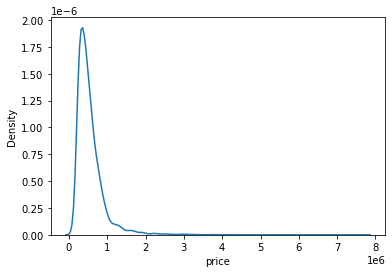

In [11]:
sns.kdeplot(y)
plt.show()

그래프가 치우쳐 있는 형태, 로그 변환으로 분포 치우침 완화

In [12]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

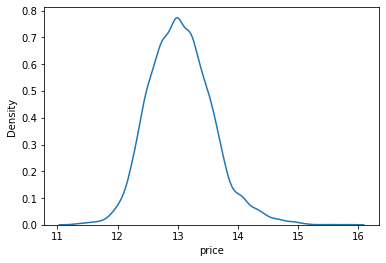

In [13]:
sns.kdeplot(y)
plt.show()

완만한 정규분포 형태로 잘 변환됌

In [14]:
train.info

<bound method DataFrame.info of          date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0      201410         3       1.00         1180      5650     1.0           0   
1      201502         2       1.00          770     10000     1.0           0   
2      201502         3       2.00         1680      8080     1.0           0   
3      201406         3       2.25         1715      6819     2.0           0   
4      201501         3       1.50         1060      9711     1.0           0   
...       ...       ...        ...          ...       ...     ...         ...   
15030  201410         4       2.50         2520      6023     2.0           0   
15031  201503         4       3.50         3510      7200     2.0           0   
15032  201405         3       2.50         1530      1131     3.0           0   
15033  201502         4       2.50         2310      5813     2.0           0   
15034  201410         2       0.75         1020      1076     2.0           0

모두 실수 또는 자료형으로 모델 학습에 활용 가능

### 모델 튜닝

#### RMSE 계산

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

#### 모델 생성

In [17]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#### randon_state 고정

In [18]:
random_state=2020 

In [19]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

#### 모델의 이름을 접근해서 얻기

In [20]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [21]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(x_train, y_train)
    
    # 예측
    y_pred = model.predict(x_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.6704088949,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125367.2973747959}

#### 위 과정을 함수로 재현

In [22]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        x_train, x_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

### 하이퍼 파라미터 튜닝 , 그리드 검색

In [23]:
from sklearn.model_selection import GridSearchCV

#### xgboost 관련 하이퍼 파라미터

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [25]:
model = LGBMRegressor(random_state=random_state)

In [26]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=None)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020),
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
grid_model.cv_results_

{'mean_fit_time': array([0.11603646, 0.12062058, 0.29997821, 0.43273172]),
 'std_fit_time': array([0.06079455, 0.01206133, 0.03492785, 0.03290953]),
 'mean_score_time': array([0.01018853, 0.01308737, 0.01477084, 0.02750401]),
 'std_score_time': array([0.00202409, 0.00135496, 0.00172112, 0.00832188]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [28]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [29]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

In [30]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


In [31]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [32]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=None):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [33]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=None)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s
[CV] max_depth=1, n_estimators=50 ....................................
[CV] ..................... max_depth=1, n_estimators=50, total=   0.1s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.1s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.1s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.2s
[CV] max_depth=1, n_estimators=100 ...................................
[CV] .................... max_depth=1, n_estimators=100, total=   0.2s
[CV] 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    5.2s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [34]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [35]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

#### 제출 

In [36]:
data_dir = os.getcwd()+'/kaggle-kakr-housing-data/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [37]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [38]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getcwd()+'/kaggle-kakr-housing-data/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
C:\Users\오순정\aifell\node\221108_exploration_kaggle/kaggle-kakr-housing-data/data/submission_lgbm_RMSLE_0.164399.csv saved!


노드에 나와있는 과정으로 진행한 경우 캐글 스코어

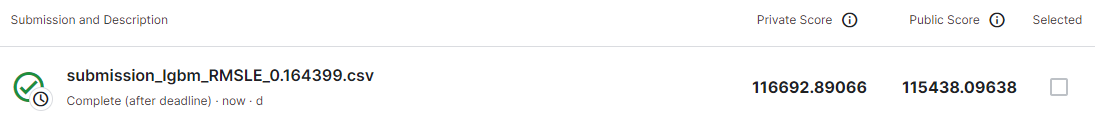

## 같은 모델(lightGBM)에 대한 하이퍼 파라미터 튜닝 

http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/ 

위 글에서 나온 중요도 순에 따라 별 3개인 파라미터에 대해 변경을 진행하겠다.

- 훈련량 – learning_rate / eta (★★★)
- 반복량 – num_iterations / nrounds (★★★)
lgb는 기본값이 100이라 너무 적은편이다. 1000이상정도는 해주도록 한다
- max_depth (★★★)
default는 -1로 제한없이 분기한다

조합 찾기

In [46]:
param_grid = {
    'n_estimators': [50, 1000],
    'max_depth': [-1,10],
    'learning_rate':[0.1,1],
    'num_iterations':[100,1000]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=None)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.4s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.4s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100 
[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.6s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100 
[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.4s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100 
[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.4s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=1000 
[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=1000, total=   3.8s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=1000 
[CV]  learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=1000, total=   3.6s
[CV] learning_rate=0.1, max_depth=-1, n_estimators=50, num_iterations=1000 
[CV] 

[CV]  learning_rate=0.1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   3.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=1000, num_iterations=1000 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  learning_rate=0.1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   3.2s
[CV] learning_rate=0.1, max_depth=10, n_estimators=1000, num_iterations=1000 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  learning_rate=0.1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   3.8s
[CV] learning_rate=1, max_depth=-1, n_estimators=50, num_iterations=100 
[CV]  learning_rate=1, max_depth=-1, n_estimators=50, num_iterations=100, total=   0.6s
[CV] learning_rate=1, max_depth=-1, n_estimators=50, num_iterations=100 
[CV]  learning_rate=1, max_depth=-1, n_estimators=50, num_iterations=10

[CV]  learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=100, total=   0.7s
[CV] learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   5.4s
[CV] learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   4.3s
[CV] learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000 
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[CV]  learning_rate=1, max_depth=10, n_estimators=1000, num_iterations=1000, total=   4.0s
[CV] learning_rate=

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.8min finished


,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
5,0.1,10,50,1000,-0.026739,0.163521
7,0.1,10,1000,1000,-0.026739,0.163521
1,0.1,-1,50,1000,-0.026767,0.163605
3,0.1,-1,1000,1000,-0.026767,0.163605
4,0.1,10,50,100,-0.027027,0.164399
6,0.1,10,1000,100,-0.027027,0.164399
0,0.1,-1,50,100,-0.027051,0.164472
2,0.1,-1,1000,100,-0.027051,0.164472
12,1.0,10,50,100,-0.050504,0.224731
14,1.0,10,1000,100,-0.050504,0.224731


더 많은 파라미터의 조합이 궁금해서 진행해 보니, learning_rate =0.1/	max_depth=10/n_estimators=50/num_iterations=1000 값의 조합이 가장 rmsle가 적게 나왔다.

추가로 찾아보니 https://velog.io/@sset2323/04-07.-LightGBM 게시글에서 num_leaves의 개수를 중심으 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안이라 명시되어있어 추가적으로 파라미터에 대한 조합을 진행해보았다.값들은 기본값들을 참고하였다.

In [48]:
param_grid = {
    'max_depth': [-1,10],
    'num_leaves':[31,1000],
    'min_child_samples':[20,80]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=None)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_depth=-1, min_child_samples=20, num_leaves=31 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=-1, min_child_samples=20, num_leaves=31, total=   0.5s
[CV] max_depth=-1, min_child_samples=20, num_leaves=31 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=-1, min_child_samples=20, num_leaves=31, total=   0.5s
[CV] max_depth=-1, min_child_samples=20, num_leaves=31 ...............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=31, total=   0.6s
[CV] max_depth=-1, min_child_samples=20, num_leaves=31 ...............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=31, total=   0.4s
[CV] max_depth=-1, min_child_samples=20, num_leaves=31 ...............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=31, total=   0.5s
[CV] max_depth=-1, min_child_samples=20, num_leaves=1000 .............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=1000, total=   3.8s
[CV] max_depth=-1, min_child_samples=20, num_leaves=1000 .............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=1000, total=   3.9s
[CV] max_depth=-1, min_child_samples=20, num_leaves=1000 .............
[CV]  max_depth=-1, min_child_samples=20, num_leaves=1000, total=   3.9s
[CV] max_depth=-1, min_child_samples=20, num_leaves=1000 .............


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   46.0s finished


,max_depth,min_child_samples,num_leaves,score,RMSLE
4,10,20,31,-0.027027,0.164399
0,-1,20,31,-0.027051,0.164472
2,-1,80,31,-0.027189,0.164891
6,10,80,31,-0.027353,0.165388
3,-1,80,1000,-0.027358,0.165402
7,10,80,1000,-0.027415,0.165575
5,10,20,1000,-0.027762,0.166620
1,-1,20,1000,-0.029058,0.170465


위 조합들을 모두 합쳐 함수에 적용하였다.

In [50]:
model = LGBMRegressor(max_depth=10, n_estimators=50, learning_rate=0.1, num_iterations=1000,min_child_samples=20, num_leaves=31,random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.19495169, 13.11873096, 14.01893003, ..., 13.05179856,
       12.72122862, 13.00310932])

In [51]:
prediction = np.expm1(prediction)
prediction

array([ 537642.88051594,  498186.08760612, 1225585.45639546, ...,
        465932.667101  ,  334778.91334668,  443790.13608839])

In [52]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.163521')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
C:\Users\오순정\aifell\node\221108_exploration_kaggle/kaggle-kakr-housing-data/data/submission_lgbm_RMSLE_0.163521.csv saved!


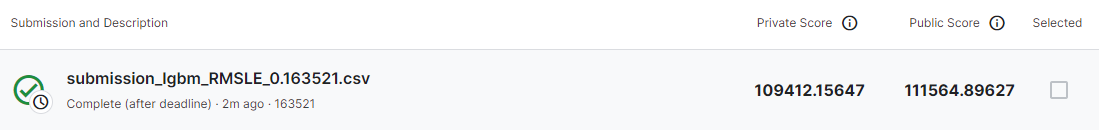